In [45]:
import torch 
from torch.distributions.bernoulli import Bernoulli
from torch.utils.data import DataLoader
import pandas as pd 
import argparse 
import numpy as np
import time 
import torch_geometric as pyg 
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from torch_geometric.loader import DataLoader 

from gsnn.models.NN import NN
from gsnn.models.GSNN import GSNN
from gsnn.models import utils 
from torch_geometric.utils import to_undirected 

from torch_geometric.data import Batch
import scipy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
res_dict = torch.load('../output/bo_opt/dti_optim_results_dict.pt')

In [47]:
res_dict['hoptim'].best_reward

({'reward': 3.5703495220084562}, {'reward': {'reward': 0.4211470964689191}})

In [48]:
res_dict['hoptim'].best_action

[1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0]

In [37]:
(~res_dict['true_action']).sum()

tensor(10)

In [116]:
acc = ((res_dict['reinforce'].best_action == 1) == res_dict['true_drug_edge_mask']).float().mean()
tp = ((res_dict['reinforce'].best_action == 1) & (res_dict['true_drug_edge_mask'] == 1)).float().sum() / res_dict['true_drug_edge_mask'].sum()
tn = ((res_dict['reinforce'].best_action == 0) & (res_dict['true_drug_edge_mask'] == 0)).float().sum() / (~res_dict['true_drug_edge_mask']).sum()
fp = ((res_dict['reinforce'].best_action == 1) & (res_dict['true_drug_edge_mask'] == 0)).float().sum() / res_dict['true_drug_edge_mask'].sum()
fn = ((res_dict['reinforce'].best_action == 0) & (res_dict['true_drug_edge_mask'] == 1)).float().sum() / (~res_dict['true_drug_edge_mask']).sum()
print(acc, tp, tn, fp, fn)

tensor(0.5080) tensor(0.5097) tensor(0.4800) tensor(0.0314) tensor(8.1200)


In [117]:
res_dict.keys()

dict_keys(['reinforce', 'node_prob', 'action_edge_dict', 'true_drug_edge_mask', 'args', 'best_reward', 'best_action', 'data', 'model_kwargs', 'training_kwargs'])

In [118]:
(res_dict['node_prob'][0] > res_dict['node_prob']).sum()

tensor(346)

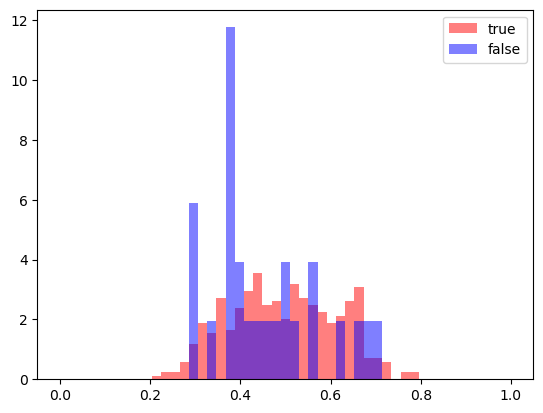

In [119]:
bins = np.linspace(0, 1, 50)

plt.figure()
plt.hist(res_dict['node_prob'][res_dict['true_drug_edge_mask']].detach(), color='r', alpha=0.5, bins=bins, label='true', density=True)
plt.hist(res_dict['node_prob'][~res_dict['true_drug_edge_mask']].detach(), color='b', alpha=0.5, bins=bins, label='false', density=True)
plt.legend()
plt.show()

In [49]:
df = res_dict['hoptim'].client.get_trials_data_frame()
df =df.assign(acc = (df[[f'a{i}' for i in range(11)]].values == (np.array(res_dict['true_action'])*1.)).mean(axis=1))
df.head()

[WARNING 11-14 10:04:32] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,reward,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,acc
0,0,0_0,COMPLETED,Sobol,1.983298,1,1,1,1,0,0,1,1,0,1,1,0.363636
1,1,1_0,COMPLETED,Sobol,1.340917,0,0,0,0,1,1,0,0,1,0,0,0.636364
2,2,2_0,COMPLETED,Sobol,4.254161,0,1,1,1,1,1,1,0,1,0,0,0.272727
3,3,3_0,COMPLETED,Sobol,3.774088,1,0,0,0,0,0,0,1,0,1,1,0.727273
4,4,4_0,COMPLETED,Sobol,4.951452,1,1,0,0,0,0,1,0,1,0,0,0.727273


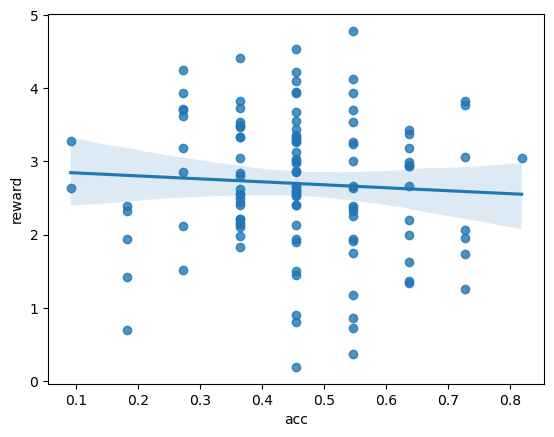

In [51]:
mdf = df.groupby([f'a{i}' for i in range(11)])[['reward', 'acc']].mean().sort_values('reward', ascending=False).reset_index()
#mdf = mdf.assign(acc = (mdf[[f'a{i}' for i in range(11)]].values == (np.array(res_dict['true_action'])*1.)).mean(axis=1))

import seaborn as sbn
plt.figure()
sbn.regplot(x='acc', y='reward', data=mdf)
plt.show()

In [20]:
(mdf[[f'a{i}' for i in range(11)]].values == (np.array(res_dict['true_action'])*1.)).mean(axis=1)

array([0.63636364, 0.63636364, 0.54545455, 0.72727273, 0.63636364,
       0.18181818, 0.45454545, 0.36363636, 0.36363636, 0.45454545,
       0.27272727, 0.54545455, 0.45454545, 0.63636364, 0.27272727,
       0.54545455, 0.63636364, 0.45454545, 0.36363636, 0.36363636,
       0.36363636, 0.36363636, 0.45454545, 0.72727273, 0.45454545,
       0.54545455, 0.63636364, 0.45454545, 0.63636364, 0.63636364,
       0.36363636, 0.36363636, 0.45454545, 0.63636364, 0.36363636,
       0.54545455, 0.63636364, 0.72727273, 0.27272727, 0.72727273,
       0.45454545, 0.36363636, 0.27272727, 0.54545455, 0.63636364,
       0.72727273, 0.54545455, 0.45454545, 0.27272727, 0.63636364,
       0.54545455, 0.54545455, 0.63636364, 0.36363636, 0.72727273,
       0.36363636, 0.36363636, 0.45454545, 0.81818182, 0.36363636,
       0.36363636, 0.54545455, 0.45454545, 0.81818182, 0.54545455,
       0.45454545, 0.54545455, 0.45454545, 0.72727273, 0.27272727,
       0.45454545, 0.36363636, 0.54545455, 0.54545455, 0.09090

In [17]:
(mdf[[f'a{i}' for i in range(11)]].values == res_dict['true_action']).mean(axis=1)

AttributeError: 'bool' object has no attribute 'mean'

[WARNING 11-14 10:05:34] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


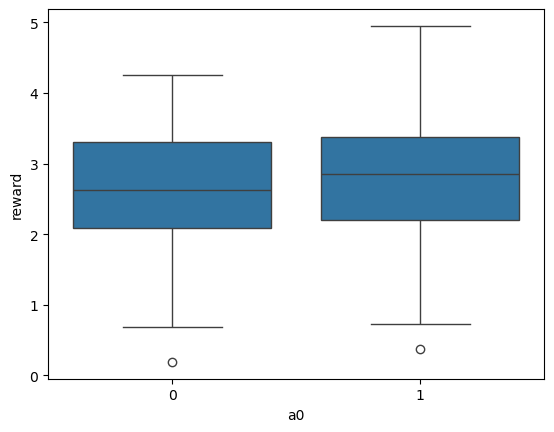

In [53]:
import seaborn as sbn

plt.figure()
sbn.boxplot(x='a0', y='reward', data=res_dict['hoptim'].client.get_trials_data_frame())
plt.show()

Object `sbn.boxplot` not found.


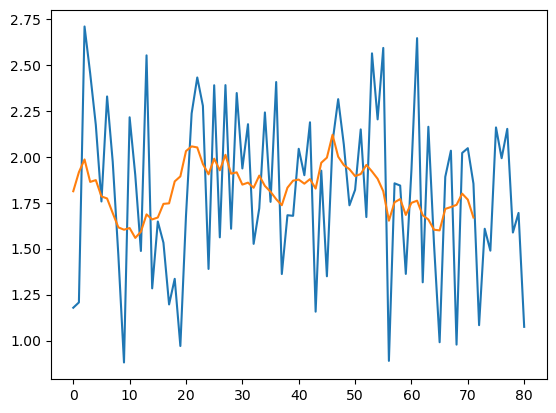

In [19]:
rs = [r.mean() for r in res_dict['hoptim'].rewards]

plt.figure()
plt.plot(rs)
plt.plot(np.convolve(rs, np.ones(10)/10, mode='valid'))
plt.show()

In [2]:
data = torch.load(f'../data/all/data.pt')

In [3]:
recorder = ExperienceRecord('../processed_data/')

actions = torch.stack(recorder.actions, dim=0).to(torch.float32)
rewards = torch.tensor(recorder.rewards).to(torch.float32)
_idx = torch.randperm(len(rewards))
n_train = 300
train_idx = _idx[:n_train]
test_idx = _idx[n_train:]

train_idx = torch.tensor([i for i in train_idx if rewards[i] != 0])

train_actions = actions[train_idx]
test_actions = actions[test_idx]

train_rewards = rewards[train_idx]
test_rewards = rewards[test_idx]

train_record = recorder 
train_record.actions = [a for i,a in enumerate(recorder.actions) if i in train_idx]
train_record.rewards = [r for i,r in enumerate(recorder.rewards) if i in train_idx]


loading experiences from disk...439 experiences loaded.


: 

In [4]:
train_kwargs={'val_prop':0.1, 
                'batch_size':50,
                'lr':1e-2,
                'wd':1e-6, 
                'patience':10,
                'epochs':100}

model_kwargs={'channels':10,
                'norm':'layer',
                'layers':10,
                'dropout':0.0,
                'bias':True,
                'share_layers':False}

venv = SurrogateEnvironment(data, 25, train_kwargs, model_kwargs)
venv.optimize(train_record)

In [41]:
test_rhat = venv.predict(test_actions)

ensemble test r2: 0.14718788862228394
ensemble test pearson: 0.39426251862459266


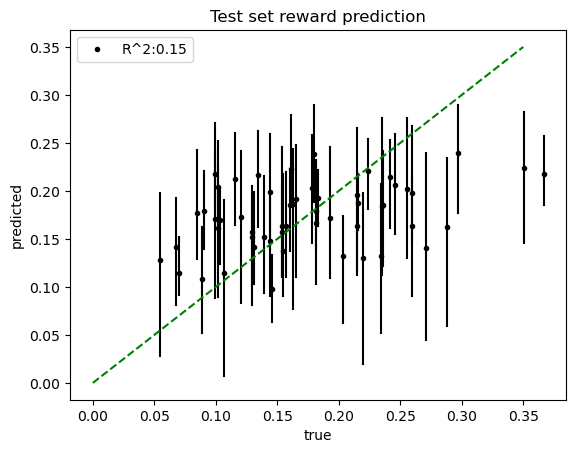

In [42]:
true_r = test_rewards.detach().cpu().numpy()
rhat = test_rhat.detach().cpu().numpy()
lcb = np.quantile(rhat, q=0.05, axis=0) 
ucb = np.quantile(rhat, q=0.95, axis=0)
rhat_mean = rhat.mean(axis=0)

nonzero_idx = true_r.nonzero()[0]
true_r = true_r[nonzero_idx]
rhat_mean = rhat_mean[nonzero_idx]
lcb = lcb[nonzero_idx]
ucb = ucb[nonzero_idx]

r2=r2_score(true_r, rhat_mean)
r = np.corrcoef(true_r, rhat_mean)[0,1]
print('ensemble test r2:', r2)
print('ensemble test pearson:', r)

plt.figure()
plt.title('Test set reward prediction')
plt.plot(true_r, rhat_mean, 'k.', label=f'R^2:{r2:.2f}')
#plt.errorbar(true_r, rhat_mean, yerr=np.clip(rhat_ci, 0, 10), fmt='o', capsize=5)
for y, lcb_, ucb_ in zip(true_r, lcb, ucb): 
    plt.plot((y, y), (lcb_,ucb_), 'k')
plt.plot((0, 0.35), (0, 0.35), 'g--')
plt.ylabel('predicted')
plt.xlabel('true')
plt.legend()
plt.show()

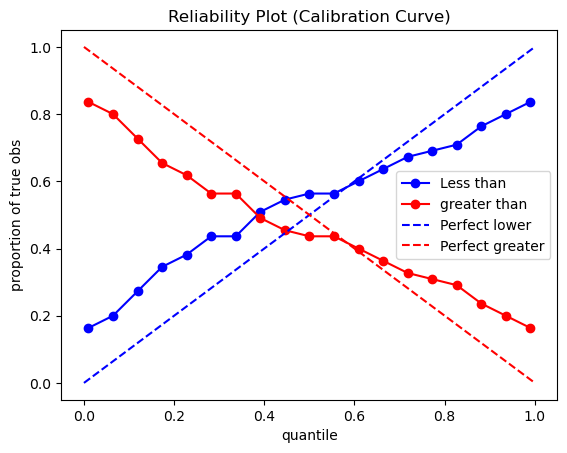

In [43]:
rhat_array = test_rhat.detach().cpu().numpy()
r_true = test_rewards.detach().cpu().numpy().ravel()

# filter obs that r_true == 0 (will be no variance)
nonzero_idxs = (r_true != 0).astype(int).nonzero()[0]
rhat_array = rhat_array[:, nonzero_idxs]
r_true = r_true[nonzero_idxs]

# Define quantile levels to evaluate
quantile_levels = np.linspace(0.01, 0.99, 19)  # From 5% to 95% in steps of 5%

# Initialize lists to hold nominal and observed proportions
nominal_proportions = []
lt_upper = []
gt_lower = []

# For each quantile level, compute the predicted interval and observed proportion
for q in quantile_levels:
    # Compute the z-score corresponding to the quantile
    #z = scipy.stats.norm.ppf((1 + q) / 2)  # Two-tailed

    # Compute the predicted interval
    bound = np.quantile(rhat_array, q=q, axis=0, method='inverted_cdf')
    # Check how many true values fall within this interval
    p_less_than_upper = ((r_true <= bound)).astype(int).mean()
    p_greater_than_lower = ((r_true >= bound)).astype(int).mean()
    nominal_proportions.append(q)
    lt_upper.append(p_less_than_upper)
    gt_lower.append(p_greater_than_lower)

# Plot the reliability diagram
plt.figure()
plt.plot(nominal_proportions, lt_upper, 'o-', c='b', label='Less than')
plt.plot(nominal_proportions, gt_lower, 'o-', c='r', label='greater than')
plt.plot([0, 1], [0, 1], linestyle='--', c='b', label='Perfect lower')
plt.plot([0, 1], [1, 0], linestyle='--', c='r', label='Perfect greater')
plt.xlabel('quantile')
plt.ylabel('proportion of true obs')
plt.title('Reliability Plot (Calibration Curve)')
plt.legend()
plt.show()


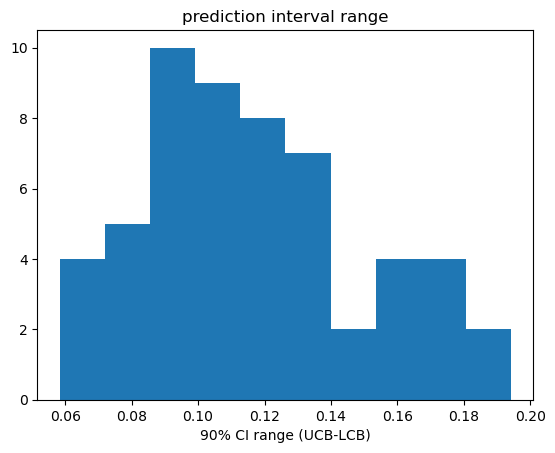

In [44]:
lcb = np.quantile(rhat_array,q=0.05, axis=0)
ucb = np.quantile(rhat_array, q=0.95, axis=0)
pi_range = ucb - lcb 
plt.figure()
plt.title('prediction interval range')
plt.hist(pi_range)
plt.xlabel('90% CI range (UCB-LCB)')
plt.show()

In [45]:

def evaluate_predictions(true_rewards, ensemble_predictions, d, alpha=0.05, comparison='less than'):
    
    lcb = np.quantile(ensemble_predictions, q=alpha, axis=0)
    ucb = np.quantile(ensemble_predictions, q=1-alpha, axis=0)

    # Compute the probability P(r </> d) for each observation
    if comparison == 'less than': 
        confident_predictions = ucb < d
        actual_compared_d = true_rewards < d
    elif comparison == 'greater than': 
        confident_predictions = lcb > d
        actual_compared_d = true_rewards > d
    else:
        raise ValueError("Invalid comparison: must be 'less than' or 'greater than'")

    # Number of confidently predicted observations
    num_confident_predictions = np.sum(confident_predictions)

    # Calculate accuracy among confident predictions
    if num_confident_predictions > 0:
        idx = np.where(confident_predictions == 1)[0]
        # For these indices, the predicted label is True (since prob >= threshold)
        # Compare to actual labels at these indices
        accuracy = (actual_compared_d[idx] == confident_predictions[idx]).mean()
    else:
        accuracy = np.nan  # No confident predictions made

    prop_confident_predictions = confident_predictions.mean()
    return prop_confident_predictions, accuracy

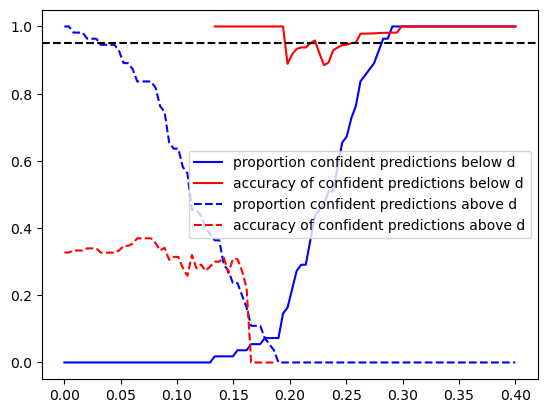

In [46]:
r_true = test_rewards.detach().cpu().numpy().ravel()
thresh = 0.05

pcp_below = []; pcp_above = []; acc_below=[]; acc_above=[]; baselines = np.linspace(0,0.4,100)
for i in baselines: 
    prop_confident_predictions, accuracy = evaluate_predictions(r_true, [*rhat_array], d=i, alpha=thresh, comparison='less than')
    pcp_below.append(prop_confident_predictions)
    acc_below.append(accuracy)

    prop_confident_predictions, accuracy = evaluate_predictions(r_true, [*rhat_array], d=i, alpha=thresh, comparison='greater than')
    pcp_above.append(prop_confident_predictions)
    acc_above.append(accuracy)

plt.figure()
plt.plot(baselines, pcp_below, 'b-', label='proportion confident predictions below d')
plt.plot(baselines, acc_below, 'r-', label='accuracy of confident predictions below d')
plt.plot(baselines, pcp_above, 'b--', label='proportion confident predictions above d')
plt.plot(baselines, acc_above, 'r--', label='accuracy of confident predictions above d')
plt.axhline(1-thresh, c='k', linestyle='--')
plt.legend()
plt.show()

In [ ]:
uni2rea = pd.read_csv(f'../../data/UniProt2Reactome_All_Levels.txt', sep='\t', header=None).rename({i:n for i,n in enumerate(['uniprot', 'pathway_id', 'url', 'name', '-', 'species'])}, axis=1)
x, pathway_ids, pathway_names = get_function_pathway_features(data, uni2rea, K=5000)
model = VAE(x, dropout=0., hidden_channels=512, latent_dim=32)
_,_ = model.train(device='cuda', epochs=2000, patience=-1, lr=1e-3, beta=1, verbose=True)
z  = model.embed(device='cpu')
x1 = torch.tensor(z, dtype=torch.float32)

data_ = pyg.data.Data() 
data_.edge_index = data['edge_index_dict']['function','to','function']
data_.num_nodes = len(data['node_names_dict']['function'])
data_.x = torch.eye(data_.num_nodes) # one hot encode nodes 
dgi = DGI(data_,  32, dropout=0, layers=5, conv='gin')
dgi.train('cuda', epochs=100, lr=1e-4)
x2 = torch.tensor(dgi.embed(), dtype=torch.float32)

x = torch.cat((x1, x2), dim=-1)
x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-8)

input_encoding = {'DRUG'    :[1,0,0,0,0], 
                  'EXPR'    :[0,1,0,0,0], 
                  'MUT'     :[0,0,1,0,0], 
                  'CNV'     :[0,0,0,1,0],
                  'METHYL'  :[0,0,0,0,1]}
x_input = torch.tensor([input_encoding[x.split('__')[0]] for x in data.node_names_dict['input']], dtype=torch.float32).view(-1,1)
x_output = torch.ones((len(data.node_names_dict['output']),1), dtype=torch.float32)
x_dict = {'input':x_input, 
            'function':x, 
            'output':x_output}

In [93]:

class QDLoss(nn.Module):
    def __init__(self, alpha=0.1, lambda_=50, soften=160.0, loss_type='qd_soft'):
        super(QDLoss, self).__init__()
        self.alpha = alpha        # Significance level
        self.lambda_ = lambda_    # Penalty coefficient
        self.soften = soften      # Soften parameter for sigmoid
        self.loss_type = loss_type  # 'qd_soft' or 'qd_hard'

    def forward(self, lower, upper, mu, targets):
        y_true = targets.view(-1)
        y_u = upper #torch.maximum(upper.view(-1), lower.view(-1))
        y_l = lower #torch.minimum(upper.view(-1), lower.view(-1))
        n_ = targets.size(0)
        
        K_HU = torch.sign(y_u - y_true).relu()
        K_HL = torch.sign(y_true - y_l).relu()
        K_H = K_HU * K_HL
        
        K_SU = torch.sigmoid(self.soften * (y_u - y_true))
        K_SL = torch.sigmoid(self.soften * (y_true - y_l))
        K_S = K_SU * K_SL
        
        MPIW_c = torch.sum((y_u - y_l)*K_H)/(torch.sum(K_H) + 1)

        #PICP_H = torch.mean(K_H)
        PICP_S = torch.mean(K_S)
        Loss_S = MPIW_c + (self.lambda_*n_ / (self.alpha*(1-self.alpha)))   *    (( 1-self.alpha) - PICP_S).relu()

        return Loss_S + F.mse_loss(mu.view(-1), targets.view(-1))

In [105]:

def train(train_idx, recorder, edge_index_dict, x_dict, model_kwargs, val_size=25, 
          batch_size=50, lr=1e-2, wd=0, patience=10, epochs=100, alpha=0.1, lambda_in=160,
          loss_type='qd_soft', soften=160):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Shuffle indices and split into training and validation sets
    idxs = torch.randperm(train_idx.size(0))
    n_train = len(idxs) - val_size
    train_data_list = recorder.get(train_idx[idxs[:n_train]], edge_index_dict, x_dict=x_dict)
    val_data_list = recorder.get(train_idx[idxs[n_train:]], edge_index_dict, x_dict=x_dict)
    val_batch = Batch.from_data_list(val_data_list).to(device)

    # Move training data to GPU
    train_data_list = [data.to(device) for data in train_data_list]

    # Create DataLoader for training data
    train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True, num_workers=0)

    # Initialize the model to output two values: lower and upper bounds
    model = HGNN2(**model_kwargs).to(device)

    # Use the QD loss function
    crit = QDLoss(alpha=alpha, lambda_=lambda_in, loss_type=loss_type, soften=soften)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    best_val = np.inf
    best_state = None
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            optim.zero_grad()
            lower, upper, mu = model(batch)  # Outputs shape: [batch_size, 2]
            targets = batch.reward.view(-1,1)  # True values

            loss = crit(lower, upper, mu, targets)

            #loss = ((lower-targets).relu()**2).mean() + ((targets-lower).relu().mean()**2) + 1e-6*((upper - lower)**2).mean() + (lower-upper).relu().mean() + F.mse_loss(mu.squeeze(), targets.squeeze())
            loss.backward()
            optim.step()

        # Validation
        with torch.no_grad():
            model.eval()
            lower, upper, mu = model(val_batch)
            # Ensure lower <= upper
            loss = crit(lower, upper, mu, val_batch.reward)

        r2 = r2_score(
            val_batch.reward.cpu().numpy().ravel(),
            mu.cpu().numpy().ravel()
        )
        #r2 = np.corrcoef(val_batch.reward.cpu().numpy().ravel(), preds.cpu().numpy().ravel())[0,1]

        if loss.item() < best_val:
            best_val = loss.item()
            best_state = model.state_dict()

        print(
            f'epoch: {epoch} ---> train loss: {loss.item():.4f} '
            f'|| val loss: {loss:.4f} || val R2: {r2:.3f}',
            end='\r'
        )

        if early_stopper.early_stop(-r2):
            break

    model.load_state_dict(best_state)
    model.eval()
    print(f'\niter stopped: {epoch} --> best R2: {best_val:.3f}')
    return model.cpu(), best_val

In [112]:
model_res = []
for i in range(1): 
    model_res.append(train(train_idx, 
                            recorder, 
                            data.edge_index_dict, 
                            x_dict, 
                            model_kwargs={'conv_type':'gat',
                                        'hidden_channels':8,
                                        'num_layers':2,
                                        'n_heads':1,
                                        'dropout':0.,},
                            val_size=50, 
                            batch_size=10, 
                            lr=5e-3, 
                            wd=0, 
                            patience=25, 
                            epochs=500,
                            alpha=0.05, 
                            lambda_in=10, 
                            soften=160,
                            loss_type='qd_soft'))

epoch: 54 ---> train loss: 1.1202 || val loss: 1.1202 || val R2: 0.7661
iter stopped: 54 --> best R2: 0.410


In [113]:
def plot_prediction_intervals(y_true, y_L, y_U, y_pred, sample_size=100):
    # Randomly sample data points if the dataset is large
    if len(y_true) > sample_size:
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        y_true_sample = y_true[indices]
        y_L_sample = y_L[indices]
        y_U_sample = y_U[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_L_sample = y_L
        y_U_sample = y_U
        y_pred_sample = y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_true_sample)), y_true_sample, color='blue', label='True Values')
    plt.scatter(range(len(y_pred_sample)), y_pred_sample, color='red', label='Predicted Midpoints')
    plt.vlines(range(len(y_L_sample)), y_L_sample, y_U_sample, color='gray', alpha=0.5, label='Prediction Intervals')

    plt.xlabel('Sample Index')
    plt.ylabel('Target Value')
    plt.title('Prediction Intervals vs. True Values')
    plt.legend()
    plt.tight_layout()
    plt.show()

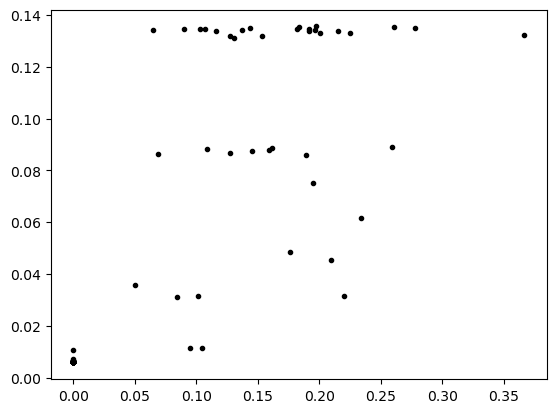

test r2 score 0.5844011902809143
proportion obs with correct ordering: 1.0
proprotion of test obs where true value is within prediction interval: 1.0


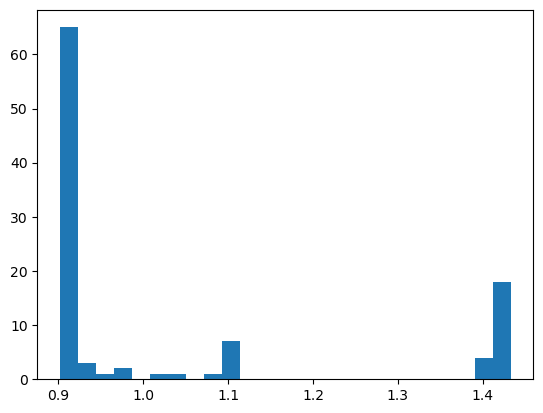

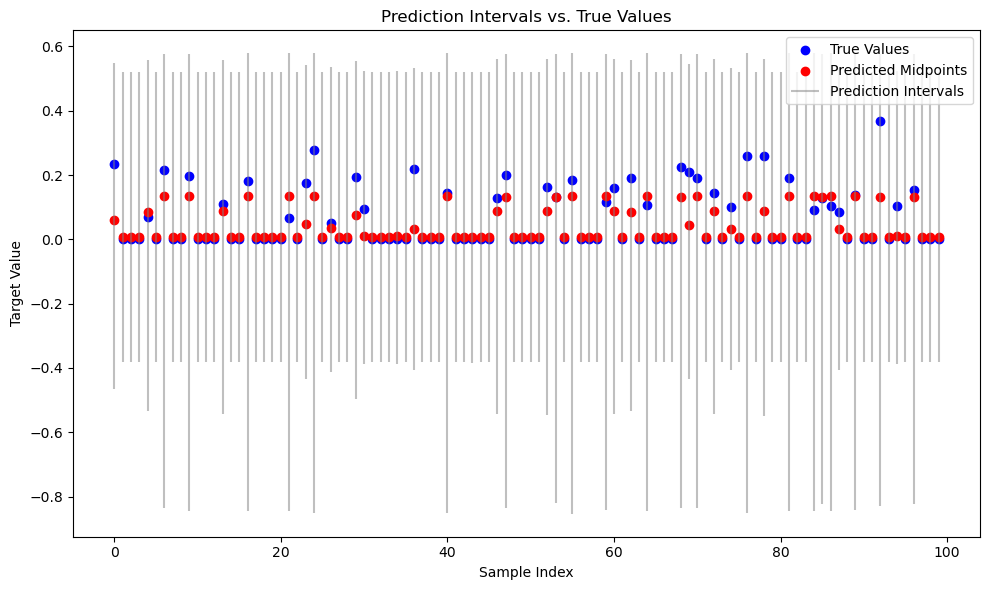

In [114]:
model = model_res[0][0].cpu()
with torch.no_grad(): lcb, ucb, med = model(val_batch)
#med = (lcb + ucb)/2

plt.figure()
plt.plot(val_batch.reward.squeeze().detach().cpu().numpy(), med.detach().cpu().numpy(), 'k.')
plt.show()

in_int = []
ordering = []
for l,u,t in zip(lcb, ucb, val_batch.reward.squeeze()):
    in_ = (t > l) & (t < u)
    in_int.append(in_)
    ordering.append(u > l)

print('test r2 score', r2_score(val_batch.reward.squeeze().detach().cpu().numpy(),
                                med.detach().cpu().numpy()))

print('proportion obs with correct ordering:', np.mean(ordering))
print('proprotion of test obs where true value is within prediction interval:', np.mean(in_int))

plt.figure()
plt.hist(ucb-lcb, bins=25)
plt.show()

plot_prediction_intervals(val_batch.reward.detach().cpu().numpy(), 
                          lcb.detach().cpu().numpy(), 
                          ucb.detach().cpu().numpy(), 
                          med.detach().cpu().numpy())

In [14]:
models = [m for m,r2 in model_res if r2 > 0.]
models = [m.to('cuda') for m in models]
[m.eval() for m in models]
val_batch = val_batch.to('cuda')

0.07726097106933594


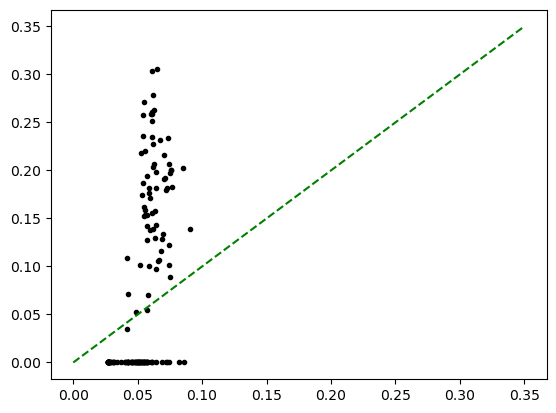

In [16]:
rhats = []
for model in models: 
    model.eval()
    with torch.no_grad(): rhats.append( model(val_batch) ) 
rhat = torch.stack(rhats, dim=-1).mean(dim=-1)

rhat = rhat.detach().cpu().numpy().ravel()
r = val_batch.reward.detach().cpu().numpy().ravel()

print(r2_score(r, rhat))

plt.figure()
plt.plot(rhat, r, 'k.')
plt.plot((0, 0.35), (0, 0.35), 'g--')
plt.show()


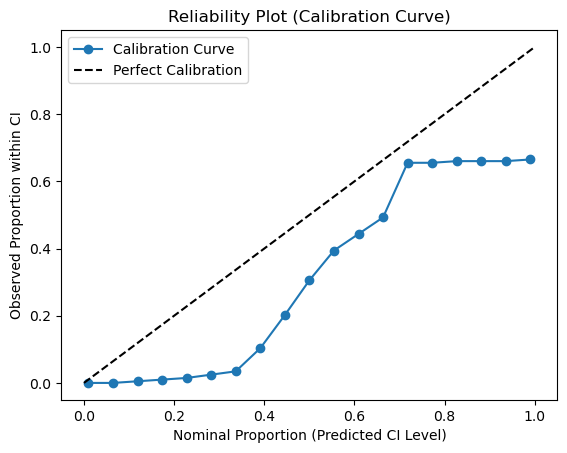

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Assuming you've already trained your ensemble and have the following:
# - models: list of trained models in the ensemble
# - val_actions: validation input data (ensure it's on the correct device)
# - val_rewards: validation true targets (ensure it's on CPU for numpy operations)

# Move val_actions to the appropriate device

# Collect predictions from each model in the ensemble
with torch.no_grad():
    rhat_list = []
    for model in models:
        model.eval()
        rhat = model(val_batch).detach().cpu().numpy().ravel()
        rhat_list.append(rhat)
    rhat_array = np.array(rhat_list)  # Shape: [num_models, num_samples]

# Compute the mean and standard deviation of the predictions
rhat_mean = np.mean(rhat_array, axis=0)
rhat_std = np.std(rhat_array, axis=0)
r_true = val_batch.reward.detach().cpu().numpy().ravel()

# Define quantile levels to evaluate
quantile_levels = np.linspace(0.01, 0.99, 19)  # From 5% to 95% in steps of 5%

# Initialize lists to hold nominal and observed proportions
nominal_proportions = []
observed_proportions = []

# For each quantile level, compute the predicted interval and observed proportion
for q in quantile_levels:
    # Compute the z-score corresponding to the quantile
    z = scipy.stats.norm.ppf((1 + q) / 2)  # Two-tailed
    # Compute the predicted interval
    lower_bound = rhat_mean - z * rhat_std
    upper_bound = rhat_mean + z * rhat_std
    # Check how many true values fall within this interval
    within_interval = ((r_true >= lower_bound) & (r_true <= upper_bound)).astype(int)
    observed_proportion = within_interval.mean()
    # Store the nominal and observed proportions
    nominal_proportions.append(q)
    observed_proportions.append(observed_proportion)

# Plot the reliability diagram
plt.figure()
plt.plot(nominal_proportions, observed_proportions, 'o-', label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Nominal Proportion (Predicted CI Level)')
plt.ylabel('Observed Proportion within CI')
plt.title('Reliability Plot (Calibration Curve)')
plt.legend()
plt.show()


In [74]:

def evaluate_predictions(true_rewards, ensemble_predictions, baseline_d, threshold=0.95, comparison='less than'):
    """
    Evaluates the predictions for a specific task, allowing for 'less than' or 'greater than' comparisons.

    Parameters:
    - true_rewards: numpy array of true rewards, shape (num_samples,)
    - ensemble_predictions: list or array of ensemble predictions, shape (num_models, num_samples)
    - baseline_d: float, the baseline value to compare against
    - threshold: float, the probability threshold (default 0.95)
    - comparison: str, 'less than' or 'greater than', specifying the comparison direction

    Returns:
    - prop_confident_predictions: float, proportion of elements confidently predicted based on threshold
    - accuracy: float, proportion of correct predictions among those confidently predicted
    """
    # Convert ensemble_predictions to array if it's not already
    predictions_array = np.array(ensemble_predictions)  # Shape: (num_models, num_samples)

    # Compute the probability P(r </> d) for each observation
    if comparison == 'less than': 
        prob_compared_d = np.mean(predictions_array < baseline_d, axis=0)
        actual_compared_d = true_rewards < baseline_d
    elif comparison == 'greater than': 
        prob_compared_d = np.mean(predictions_array > baseline_d, axis=0)
        actual_compared_d = true_rewards > baseline_d
    else:
        raise ValueError("Invalid comparison: must be 'less than' or 'greater than'")

    # Identify observations where P(r </> d) >= threshold
    confident_predictions = prob_compared_d >= threshold

    # Number of confidently predicted observations
    num_confident_predictions = np.sum(confident_predictions)

    # Calculate accuracy among confident predictions
    if num_confident_predictions > 0:
        idx = np.where(confident_predictions)[0]
        # For these indices, the predicted label is True (since prob >= threshold)
        # Compare to actual labels at these indices
        correct_predictions = actual_compared_d[idx]
        accuracy = correct_predictions.mean()
    else:
        accuracy = np.nan  # No confident predictions made

    prop_confident_predictions = num_confident_predictions / len(prob_compared_d)
    return prop_confident_predictions, accuracy

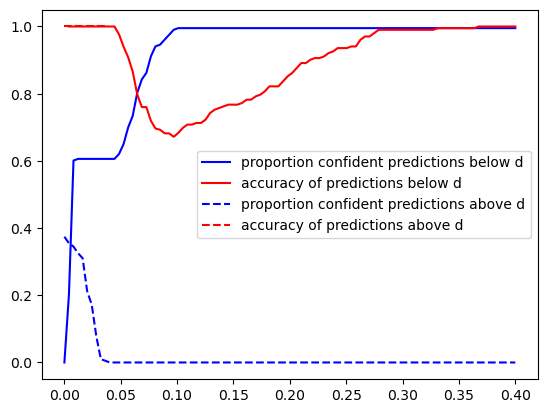

In [75]:
pcp_below = []; pcp_above = []; acc_below=[]; acc_above=[]; baselines = np.linspace(0,0.4,100)
for i in baselines: 
    prop_confident_predictions, accuracy = evaluate_predictions(r_true, rhat_list, baseline_d=i, threshold=0.99, comparison='less than')
    pcp_below.append(prop_confident_predictions)
    acc_below.append(accuracy)

    prop_confident_predictions, accuracy = evaluate_predictions(r_true, rhat_list, baseline_d=i, threshold=0.99, comparison='greater than')
    pcp_above.append(prop_confident_predictions)
    acc_above.append(accuracy)

plt.figure()
plt.plot(baselines, pcp_below, 'b-', label='proportion confident predictions below d')
plt.plot(baselines, acc_below, 'r-', label='accuracy of predictions below d')
plt.plot(baselines, pcp_above, 'b--', label='proportion confident predictions above d')
plt.plot(baselines, acc_above, 'r--', label='accuracy of predictions above d')
plt.legend()
plt.show()

In [22]:
# debatable utility predicting greater than d 

# significant utility predicting below d 

# use to take virtual steps if a candidate action is less than baseline 

1.0

In [18]:
num_confident_predictions

92

In [19]:
accuracy

1.0

In [ ]:
# TODO: try this with out HGNN ... were getting way better performances
# can use different subsetting method, don't need a mask, just create subgraphs

In [ ]:
recorder = ExperienceRecord('../processed_data/')

actions = torch.stack(recorder.actions, dim=0).to(torch.float32)
rewards = torch.tensor(recorder.rewards).to(torch.float32)
_idx = torch.randperm(len(rewards))
train_idx = _idx[:250]
val_idx = _idx[250:]

train_actions = actions[train_idx]
train_rewards = rewards[train_idx]

val_actions = actions[val_idx]
val_rewards = rewards[val_idx]

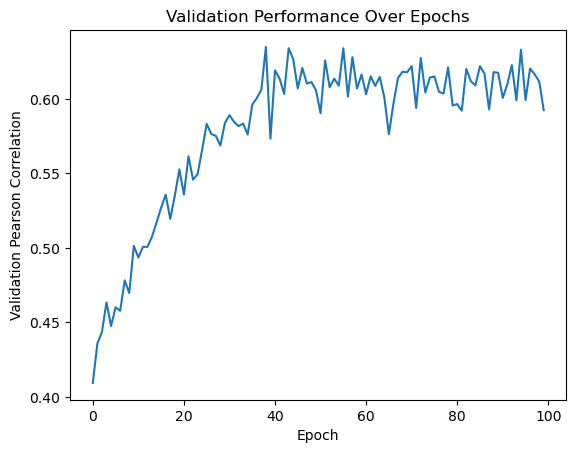

In [324]:
device = 'cuda'

train_actions = train_actions.to(device)
val_actions = val_actions.to(device)
train_rewards = train_rewards.to(device)
val_rewards = val_rewards.to(device)

num_models = 50  # Number of models in the ensemble

# Initialize lists to hold models and optimizers
models = []
optims = []
subsets = [torch.randperm(train_rewards.size(0), device=device)[:100] for _ in range(num_models)]
crit = torch.nn.MSELoss()

# Create the ensemble of models and their corresponding optimizers
for _ in range(num_models):
    model = NN(
        in_channels=len(data.node_names_dict['function']),
        hidden_channels=24,
        out_channels=1,
        layers=1,
        dropout=0.05,
        norm=torch.nn.BatchNorm1d,
        nonlin=torch.nn.GELU
    ).to(device)
    models.append(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
    optims.append(optimizer)

val_score = []

# Training loop
for epoch in range(100):
    for model, optimizer, batch_idx in zip(models, optims, subsets):
        optimizer.zero_grad()
        outputs = model(train_actions[batch_idx])
        loss = crit(outputs.squeeze(), train_rewards[batch_idx])
        loss.backward()
        optimizer.step()

    # Validation phase
    with torch.no_grad():
        rhat_list = []
        for model in models:
            rhat = model(val_actions).detach().cpu().numpy().ravel()
            rhat_list.append(rhat)
        # Average predictions from all models
        rhat_avg = np.mean(rhat_list, axis=0)
        r = val_rewards.detach().cpu().numpy()
        # Compute validation score using Pearson correlation
        val_score.append(np.corrcoef(rhat_avg, r)[0, 1])

    # Optional: print progress
    # print(f'Epoch {epoch}: Validation Pearson Correlation: {val_score[-1]:.3f}')

[m.eval() for m in models]

# Plot validation scores over epochs
plt.figure()
plt.plot(val_score)
plt.xlabel('Epoch')
plt.ylabel('Validation Pearson Correlation')
plt.title('Validation Performance Over Epochs')
plt.show()

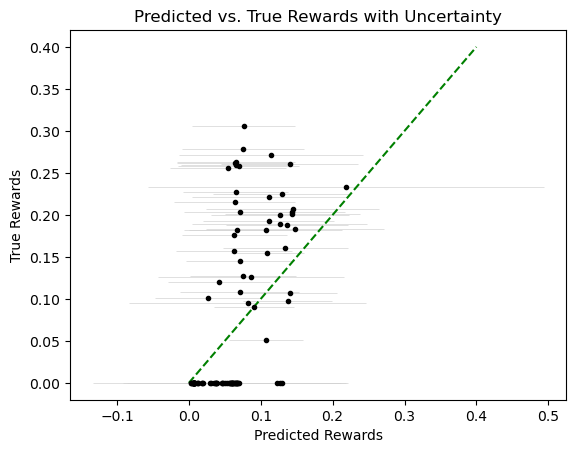

In [325]:
# Final evaluation on validation set
with torch.no_grad():
    rhat_list = []
    for model in models:
        model.eval()
        rhat = model(val_actions).detach().cpu().numpy().ravel()
        rhat_list.append(rhat)
    rhat_array = np.array(rhat_list)  # Shape: [num_models, num_samples]
    rhat_avg = np.mean(rhat_array, axis=0)
    rhat_std = np.std(rhat_array, axis=0)  # Standard deviation across models
    r = val_rewards.detach().cpu().numpy()

# Scatter plot of predicted vs true rewards with error bars
plt.figure()
plt.errorbar(
    rhat_avg, r, xerr=rhat_std, fmt='k.', ecolor='lightgray',
    elinewidth=0.5, capsize=0
)
plt.plot([0, 0.4], [0, 0.4], 'g--')
plt.xlabel('Predicted Rewards')
plt.ylabel('True Rewards')
plt.title('Predicted vs. True Rewards with Uncertainty')
plt.show()

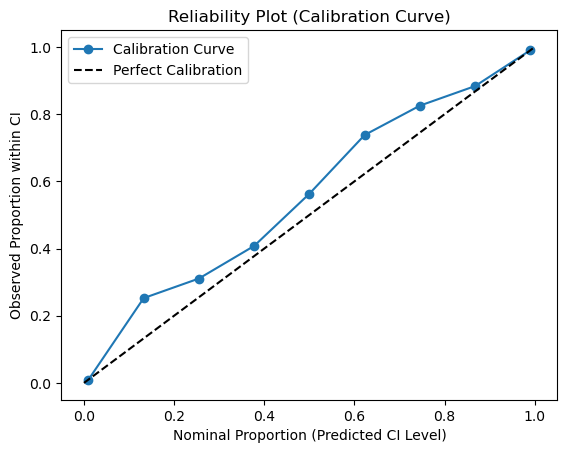

In [327]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Assuming you've already trained your ensemble and have the following:
# - models: list of trained models in the ensemble
# - val_actions: validation input data (ensure it's on the correct device)
# - val_rewards: validation true targets (ensure it's on CPU for numpy operations)

# Move val_actions to the appropriate device
val_actions = val_actions.to(device)

# Collect predictions from each model in the ensemble
with torch.no_grad():
    rhat_list = []
    for model in models:
        model.eval()
        rhat = model(val_actions).detach().cpu().numpy().ravel()
        rhat_list.append(rhat)
    rhat_array = np.array(rhat_list)  # Shape: [num_models, num_samples]

# Compute the mean and standard deviation of the predictions
rhat_mean = np.mean(rhat_array, axis=0)
rhat_std = np.std(rhat_array, axis=0)
r_true = val_rewards.detach().cpu().numpy().ravel()

# Define quantile levels to evaluate
quantile_levels = np.linspace(0.01, 0.99, 9)  # From 5% to 95% in steps of 5%

# Initialize lists to hold nominal and observed proportions
nominal_proportions = []
observed_proportions = []

# For each quantile level, compute the predicted interval and observed proportion
for q in quantile_levels:
    # Compute the z-score corresponding to the quantile
    z = scipy.stats.norm.ppf((1 + q) / 2)  # Two-tailed
    # Compute the predicted interval
    lower_bound = rhat_mean - z * rhat_std
    upper_bound = rhat_mean + z * rhat_std
    # Check how many true values fall within this interval
    within_interval = ((r_true >= lower_bound) & (r_true <= upper_bound)).astype(int)
    observed_proportion = within_interval.mean()
    # Store the nominal and observed proportions
    nominal_proportions.append(q)
    observed_proportions.append(observed_proportion)

# Plot the reliability diagram
plt.figure()
plt.plot(nominal_proportions, observed_proportions, 'o-', label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Nominal Proportion (Predicted CI Level)')
plt.ylabel('Observed Proportion within CI')
plt.title('Reliability Plot (Calibration Curve)')
plt.legend()
plt.show()


In [259]:
device = 'cuda'
model = NN(in_channels=len(data.node_names_dict['function']), hidden_channels=10, out_channels=1, layers=2, dropout=0., norm=None)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
crit = torch.nn.MSELoss()

val_score = []
for epoch in range(1000): 
    optim.zero_grad()
    outputs = model(train_actions)
    loss = crit(outputs.squeeze(), train_rewards)
    loss.backward()
    optim.step()

    with torch.no_grad(): 
        rhat = model(val_actions).detach().cpu().numpy().ravel()
        r = val_rewards.detach().cpu().numpy()
        val_score.append(np.corrcoef(rhat, r)[0,1])

    #print(f'epoch: {epoch}: loss-->{loss:.4f} | val pearson: {np.corrcoef(rhat, r)[0,1]:.3f}')

plt.figure()
plt.plot(val_score)
plt.show()

rhat = model(val_actions).detach().cpu().numpy().ravel()
r = val_rewards.detach().cpu().numpy()

plt.figure()
plt.plot(rhat, r, 'k.')
plt.plot((0,.4), (0,.4), 'g--')
plt.xlabel('predicted rewards')
plt.ylabel('true rewards')
plt.show()

KeyboardInterrupt: 

In [ ]:

train_list = [a for a in actions[train_idx]]
val_list = [a for a in actions[val_idx]]
train_rewards = [r for r in rewards[train_idx]]
val_rewards = [r for r in rewards[val_idx]]

train_dataset = EntityDataset(train_list, train_rewards)
train_loader = DataLoader(train_dataset, batch_size=50, collate_fn=collate_fn, num_workers=5, shuffle=True)

val_dataset = EntityDataset(val_list, val_rewards)
val_loader = DataLoader(val_dataset, batch_size=50, collate_fn=collate_fn, num_workers=5)

In [184]:
device = 'cuda'
model = SetTransformer(num_entities=len(data.node_names_dict['function']), dim_hidden=64).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
crit = torch.nn.MSELoss()

for epoch in range(100): 
    train_loss = 0
    for padded_data, labels, mask in train_loader:
        optim.zero_grad()
        outputs = model(padded_data.to(device), mask=mask.to(device))
        loss = crit(outputs, labels.to(device))
        loss.backward()
        optim.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    rhat, r = predict_loader(val_loader, model, device)

    print(f'epoch: {epoch}: loss-->{train_loss:.4f} | val pearson: {np.corrcoef(rhat, r)[0,1]:.4f}')

epoch: 0: loss-->0.7454 | val pearson: -0.2975
epoch: 1: loss-->0.0130 | val pearson: 0.1040
epoch: 2: loss-->0.0155 | val pearson: 0.3607
epoch: 3: loss-->0.0116 | val pearson: 0.3985
epoch: 4: loss-->0.0105 | val pearson: -0.0874
epoch: 5: loss-->0.0098 | val pearson: -0.1362
epoch: 6: loss-->0.0098 | val pearson: -0.2110
epoch: 7: loss-->0.0097 | val pearson: -0.2375
epoch: 8: loss-->0.0106 | val pearson: -0.2240
epoch: 9: loss-->0.0109 | val pearson: -0.2239
epoch: 10: loss-->0.0102 | val pearson: -0.2603
epoch: 11: loss-->0.0111 | val pearson: -0.2259
epoch: 12: loss-->0.0117 | val pearson: -0.2408
epoch: 13: loss-->0.0097 | val pearson: -0.2524
epoch: 14: loss-->0.0104 | val pearson: -0.2340
epoch: 15: loss-->0.0097 | val pearson: -0.2004
epoch: 16: loss-->0.0098 | val pearson: -0.2163
epoch: 17: loss-->0.0105 | val pearson: -0.1729
epoch: 18: loss-->0.0101 | val pearson: -0.1473
epoch: 19: loss-->0.0098 | val pearson: -0.1830
epoch: 20: loss-->0.0098 | val pearson: -0.1145
epoch

In [185]:
rhat,r = predict_loader(val_loader, model=model, device=device)

In [186]:
np.corrcoef(rhat, r)[0,1]

0.3087943233783406

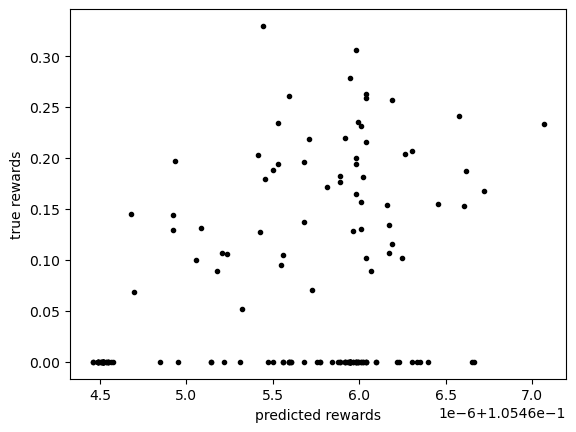

In [187]:
plt.figure()
plt.plot(rhat, r, 'k.')
plt.xlabel('predicted rewards')
plt.ylabel('true rewards')
plt.show()